# Building a Predictive Model for McAfee V2

Our objective is to train and evaluate a predictive model that predicts whether employees click on a phishing url to visit a website or not. In this version, we will use more advanced methods such as using multiple classifiers. Primarily, we focus on the followings:

1- Stacking classifiers

2- Voting classifiers

3- Hyperparameter optimization

## 1. Notebook Styling and Package Management

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

## 2. Load Data

In [2]:
trainInput = pd.read_csv("Data/Phishing_TrainSample.csv") 
testInput = pd.read_csv("Data/Phishing_TestSample.csv")

In [3]:
trainData = trainInput.drop(columns = 'Visit')
trainLabels = LabelEncoder().fit_transform(trainInput.Visit)

testData = testInput.drop(columns = 'Visit')
testLabels = LabelEncoder().fit_transform(testInput.Visit)

## 3. Train/ Evaluate a Stacked Classifier

In [4]:
%%time
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50, 
                                  random_state=42)),
    ('knn', make_pipeline(StandardScaler(),
                          KNeighborsClassifier(n_neighbors=5)))]
clf = StackingClassifier(
    estimators = estimators, 
    final_estimator = LogisticRegression(),
    n_jobs = -1, verbose=True
)

clf.fit(trainData, trainLabels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished


CPU times: user 80.4 ms, sys: 189 ms, total: 270 ms
Wall time: 11.3 s


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=42)),
                               ('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier())]))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   verbose=True)

We first import custom functions from a custom package called custom_functions. File custom_functions.py should be in the active directory.

In [5]:
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


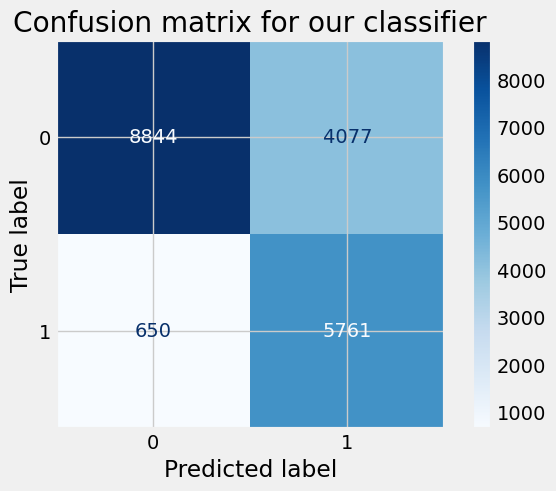

In [6]:
plot_conf_mat(clf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [7]:
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, 
                         testLabels)

Accuracy: 75.55
PrecisionNegative: 93.15
PrecisionPositive: 58.56
RecallNegative: 68.45
RecallPositive: 89.86
AUC Score: 84.90



In [8]:
print("F1 Score:",f1_score(testLabels, predictedLabels, 
                           average='micro'))

F1 Score: 0.755483136768053


AUC Score = 84.899


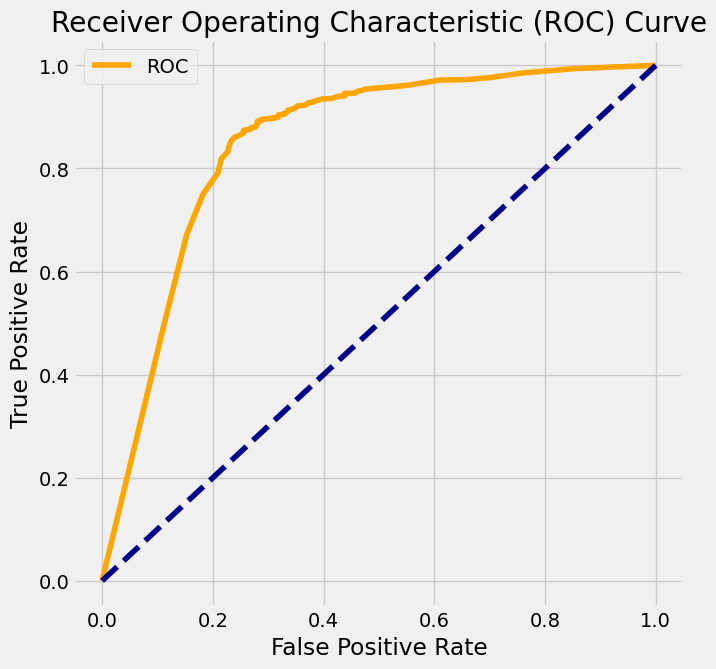

In [9]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

## 4. Train/ Evaluate Voting Classifiers 

In [10]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = XGBClassifier(random_state=1)

vclf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('xgb', clf3)], 
                        voting='soft')

vclf.fit(trainData, trainLabels)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=No...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1, ...))],
                 voting='soft')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


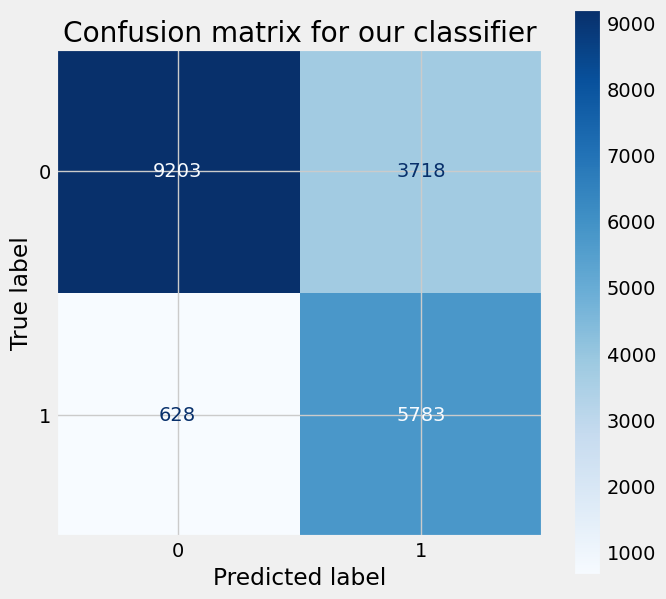

In [11]:
plot_conf_mat(vclf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [12]:
predictedProbabilities = vclf.predict_proba(testData)
predictedLabels = vclf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, 
                         testLabels)

Accuracy: 77.52
PrecisionNegative: 93.61
PrecisionPositive: 60.87
RecallNegative: 71.23
RecallPositive: 90.20
AUC Score: 85.25



In [13]:
print("F1 Score:",f1_score(testLabels, predictedLabels, 
                           average='micro'))

F1 Score: 0.7751913925098283


AUC Score = 85.250


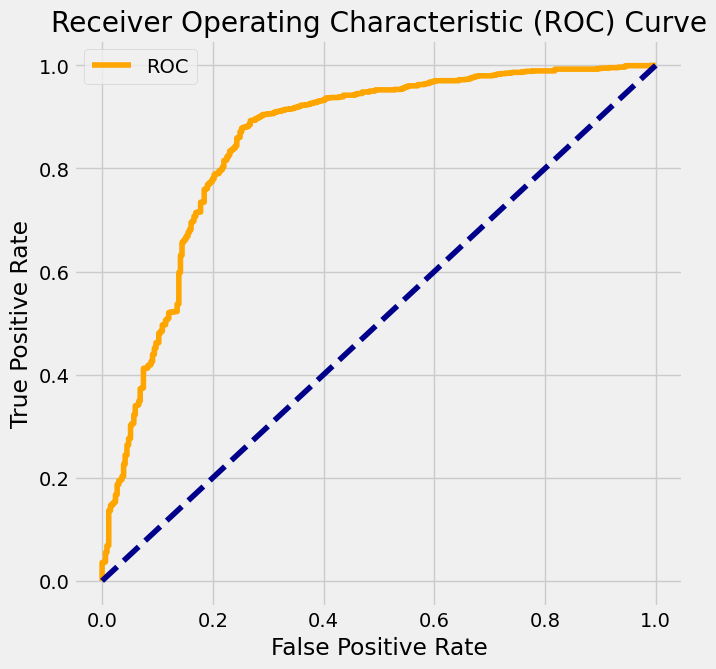

In [14]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

## 5. Use HyperOpt Package to Optimize Hyperparameters

What are Hyper Parameters?

Hyper parameters are more like handles available to control the output or the behavior of the algorithm used for modeling. They can be supplied to algorithms as arguments. For eg: model= DecisionTreeClassifier(criterion=’entropy’), here the criterion entropy is the hyper parameter passed.

Typically, we can use one of the following two methods to fine-tune the hyperparameters in the algorithms:

* RandomSearchCV (only a few samples are randomly selected)
* GridSearchCV (considers all possible combinations of hyperparameters)

These two approaches can give us reasonably good values for the hyperparameters in our models. That being said, even if we use both of these two approaches, we may not be able to find the "optimal" values for the hyperparameters in our models. To address this issue, we can use advanced packages that are designed to find the optimal values for hyperparameters in our models. This blog post (https://neptune.ai/blog/hyperparameter-tuning-in-python-complete-guide) provides a great review of the existing packages that are created to find optimal hyperparameter values. From the list provided in the blog post, we use "hyperopt" to find the optimal hyperparameter values for an XGBoost classifier in the following example:     

In [15]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [16]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [17]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 20),
        'eta': hp.uniform ('eta', 0.1,0.9),
        'seed': 0,
        'random_state': 1
    }

In [18]:
from sklearn.metrics import roc_auc_score

def objective(space):
    clf=XGBClassifier(
        random_state = space['random_state'],
        eta = space['eta'],
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( trainData, trainLabels), ( testData, testLabels)]
    
    clf.fit(trainData, trainLabels,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(testData)
    accuracy = roc_auc_score(testLabels, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [19]:
%%capture --no-display

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [20]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8182902035285777, 'eta': 0.7974676615890914, 'gamma': 7.870558816361137, 'max_depth': 13.0, 'min_child_weight': 4.0, 'n_estimators': 180.0, 'reg_alpha': 48.0, 'reg_lambda': 0.8050195284705558}


Now that we have the best values, we can create a new XGBoost classifier using the optimal values:

In [21]:
best_hyperparams = {
 'colsample_bytree': 0.8182902035285777, 
 'eta': 0.7974676615890914, 
 'gamma': 7.870558816361137, 
 'max_depth': 13, # Should be int
 'min_child_weight': 4, # Should be int
 'n_estimators': 180, # Should be int
 'reg_alpha': 48.0, 
 'reg_lambda': 0.8050195284705558}

In [22]:
best_xgb = XGBClassifier(**best_hyperparams, random_state=1)
best_xgb.fit(trainData, trainLabels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8182902035285777, early_stopping_rounds=None,
              enable_categorical=False, eta=0.7974676615890914,
              eval_metric=None, feature_types=None, gamma=7.870558816361137,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.797467649,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=4,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [23]:
predictedProbabilities = best_xgb.predict_proba(testData)
predictedLabels = best_xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 75.56
PrecisionNegative: 91.49
PrecisionPositive: 58.91
RecallNegative: 69.93
RecallPositive: 86.90
AUC Score: 84.52



## What is next?

So far, we learned about some of the advanced ways to train classifiers for tabular (structured) data. However, recent developments in the field of deep learning has opened new ways of training classifiers for tabular data. Mainly, Transformers (which we learn about in detail in DA3) have been found useful for these types of tasks. In DA3, we will learn how to use transformers for processing structured (tabular), unstructured (e.g., NLP, computer vision, video, sound), and mixed data (both structured and tabular data).   

In the meantime, if you cannot wait until the next mod, feel free to take a look at the following packages:

* tabtransformertf (pip install tabtransformertf)
* tab-transformer-pytorch (pip install tab-transformer-pytorch)

There are numerous examples that show how Transformers can be used for tabular data: 

*  https://towardsdatascience.com/improving-tabtransformer-part-1-linear-numerical-embeddings-dbc3be3b5bb5

* https://towardsdatascience.com/pytorch-widedeep-deep-learning-for-tabular-data-9cd1c48eb40d

* https://keras.io/examples/structured_data/tabtransformer/ and https://huggingface.co/spaces/keras-io/TabTransformer_Classification and https://huggingface.co/keras-io/tab_transformer

* https://towardsdatascience.com/improving-tabtransformer-part-1-linear-numerical-embeddings-dbc3be3b5bb5